In [1]:
import monai
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import ImageGrid
import skimage.io as io
import os
from skimage.transform import resize
import torchio as tio
import pandas as pd 
import sys
import pathlib
import SimpleITK as sitk
from tqdm.notebook import tqdm

#The following is cloned from the repository 
from hecktor.src.data.utils import read_nifti, write_nifti, get_attributes, resample_sitk_image

## SimpleITK

In [2]:
def get_attributes(sitk_image):
    """Get physical space attributes (meta-data) of the image."""
    attributes = {}
    attributes['orig_pixelid'] = sitk_image.GetPixelIDValue()
    attributes['orig_origin'] = sitk_image.GetOrigin()
    attributes['orig_direction'] = sitk_image.GetDirection()
    attributes['orig_spacing'] = np.array(sitk_image.GetSpacing())
    attributes['orig_size'] = np.array(sitk_image.GetSize(), dtype=np.int64)
    return attributes

In [3]:
def resample_image(itk_image, out_spacing=(1.0, 1.0, 1.0), out_size = None, 
                                interpolate = sitk.sitkNearestNeighbor):
    '''
    interpolator
    Available interpolators:
        - sitk.sitkNearestNeighbor : nearest
        - sitk.sitkLinear : linear
        - sitk.sitkGaussian : gaussian
        - sitk.sitkLabelGaussian : label_gaussian
        - sitk.sitkBSpline : bspline
        - sitk.sitkHammingWindowedSinc : hamming_sinc
        - sitk.sitkCosineWindowedSinc : cosine_windowed_sinc
        - sitk.sitkWelchWindowedSinc : welch_windowed_sinc
        - sitk.sitkLanczosWindowedSinc : lanczos_windowed_sinc
    '''

    # original_spacing = itk_image.GetSpacing()
    # original_size = itk_image.GetSize()

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())
    resample.SetInterpolator(interpolate)

    return resample.Execute(itk_image) 

In [1]:
#Take specific slices from the image
img = nib.load("/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_ceT1.nii.gz")
img = img.slicer[:,:, 30:50]
img.to_filename('try.nii.gz')

#Read Sitk Image 
img = sitk.ReadImage('path')

#Convert to an array, shape comes as (depth, width, length)
nii_data = sitk.GetArrayFromImage(img)

#Transpose size to (width, length, depth)
nii_data = np.transpose(nii_data, (1,2,0))

#Resample image 
img_resampled = resample_image(img, out_size= [224, 224, 10], interpolate = sitk.sitkNearestNeighbor)
target_size = list(img.GetSize())
attributes = get_attributes(img)

#Write Sitk image
writer = sitk.ImageFileWriter()
writer.SetImageIO("NiftiImageIO")
writer.SetFileName('path')
writer.Execute(img)

(120, 512, 512)
[0. 1.]


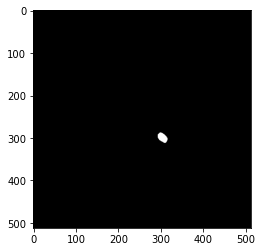

In [ ]:
lb_img = sitk.ReadImage('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_2_Label.nii.gz')
nii_data_lb = sitk.GetArrayFromImage(lb_img)
print(nii_data_lb.shape)
print(np.unique(nii_data_lb[37]))
plt.imshow(nii_data_lb[37], cmap="gray")

(120, 512, 512)
[   0    1    2 ... 2246 2332 2396]


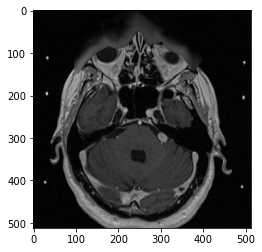

In [19]:
org_img = sitk.ReadImage('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_2_ceT1.nii.gz')
nii_data_org = sitk.GetArrayFromImage(org_img)
print(nii_data_org.shape)
print(np.unique(nii_data_org[37]))
plt.imshow(nii_data_org[37], cmap="gray")

[0. 1. 2.]


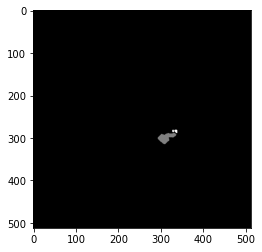

In [29]:
print(np.unique(nii_data_lb[33]))
plt.imshow(nii_data_lb[33], cmap="gray")

[   0    1    2 ... 2238 2294 2304]


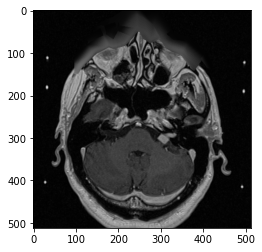

In [30]:
print(np.unique(nii_data_org[33]))
plt.imshow(nii_data_org[33], cmap="gray")

In [5]:
import itk

input_image = itk.imread('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_2_Label.nii.gz')

resize_filter = itk.ResampleImageFilter.New(input_image)
output_spacing = [1,1,1]
resize_filter.SetOutputSpacing(output_spacing)
output_size = [256,256,120]
resize_filter.SetSize(output_size)

nearest_neighbor_interpolator = itk.NearestNeighborInterpolateImageFunction.New(input_image)
resize_filter.SetInterpolator(nearest_neighbor_interpolator)

In [ ]:
resized_data = itk.GetArrayFromImage(resize_filter)
print(np.unique(resized_data[35]))
plt.imshow(resized_data[35], cmap= "gray")

In [ ]:
img_resampled = resample_image(org_img, out_size= [256, 256, 120], interpolate = sitk.sitkNearestNeighbor)
img_resampled_data = sitk.GetArrayFromImage(img_resampled)
print(np.unique(img_resampled_data[35]))
plt.imshow(img_resampled_data[35], cmap= "gray")

### SAVE 3D IMAGES WITH CONSISTENT SIZE AND SPACING

In [5]:
INPUT_FOLDER= "/home/shahad.hardan/Documents/crossMoDA20222/training_source/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/consistent_3D_source/"

for k in os.listdir(INPUT_FOLDER):
    #Read Sitk Image 
    img = sitk.ReadImage(INPUT_FOLDER+k)
    depth = img.GetSize()[2]
    #Resample image 
    img_resampled = resample_image(img, out_size= [256, 256, depth])

    #Write Sitk image
    writer = sitk.ImageFileWriter()
    writer.SetImageIO("NiftiImageIO")
    writer.SetFileName(OUTPUT_FOLDER+k)
    writer.Execute(img_resampled)

In [6]:
INPUT_FOLDER= "/home/shahad.hardan/Documents/crossMoDA20222/training_target/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/consistent_3D_target/"

for k in os.listdir(INPUT_FOLDER):
    #Read Sitk Image 
    img = sitk.ReadImage(INPUT_FOLDER+k)
    depth = img.GetSize()[2]
    #Resample image  
    img_resampled = resample_image(img, out_size= [256, 256, depth])

    #Write Sitk image
    writer = sitk.ImageFileWriter()
    writer.SetImageIO("NiftiImageIO")
    writer.SetFileName(OUTPUT_FOLDER+k)
    writer.Execute(img_resampled)

### Save 3D Images with 20 Slices

In [6]:
INPUT_FOLDER= "/home/shahad.hardan/Documents/crossMoDA20222/training_source/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/3D_training_source_20/"

for k in os.listdir(INPUT_FOLDER):

    img = nib.load(INPUT_FOLDER+k)
    
    if img.shape[2] == 120:
        img = img.slicer[:,:, 25:45]
        img.to_filename(OUTPUT_FOLDER+k)
    elif img.shape[2]==160:
        img = img.slicer[:,:, 30:50]
        img.to_filename(OUTPUT_FOLDER+k)
    elif img.shape[2]==50:
        img = img.slicer[:,:, 15:35]
        img.to_filename(OUTPUT_FOLDER+k)

In [7]:
INPUT_FOLDER= "/home/shahad.hardan/Documents/crossMoDA20222/training_target/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/3D_training_target_20/"

for k in os.listdir(INPUT_FOLDER):

    img = nib.load(INPUT_FOLDER+k)
    
    if img.shape[2] == 20:
        img.to_filename(OUTPUT_FOLDER+k)
    elif img.shape[2]==40:
        img = img.slicer[:,:, 10:30]
        img.to_filename(OUTPUT_FOLDER+k)
    elif img.shape[2]==50:
        img = img.slicer[:,:, 15:35]
        img.to_filename(OUTPUT_FOLDER+k)
    elif img.shape[2]==70:
        img = img.slicer[:,:, 25:45]
        img.to_filename(OUTPUT_FOLDER+k)
    elif img.shape[2]==80:
        img = img.slicer[:,:, 30:50]
        img.to_filename(OUTPUT_FOLDER+k)
        

In [5]:
INPUT_FOLDER= "/home/shahad.hardan/Documents/crossMoDA20222/3D_training_source_20/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/data_3D/3D_training_source_10/"

for k in os.listdir(INPUT_FOLDER):
    #Read Sitk Image 
    if "Label" not in k:
        img = sitk.ReadImage(INPUT_FOLDER+k)

        #Resample image 
        img_resampled = resample_image(img, out_size= [256, 256, 16], interpolate = sitk.sitkNearestNeighbor)

        #Write Sitk image
        writer = sitk.ImageFileWriter()
        writer.SetImageIO("NiftiImageIO")
        writer.SetFileName(OUTPUT_FOLDER+k)
        writer.Execute(img_resampled)

In [12]:
INPUT_FOLDER= "/home/shahad.hardan/Documents/crossMoDA20222/3D_training_target_20/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/data_3D/3D_training_target_16/"

for k in os.listdir(INPUT_FOLDER):
    #Read Sitk Image 
    img = sitk.ReadImage(INPUT_FOLDER+k)

    #Resample image 
    img_resampled = resample_image(img, out_size= [256, 256, 16], interpolate = sitk.sitkNearestNeighbor)

    #Write Sitk image
    writer = sitk.ImageFileWriter()
    writer.SetImageIO("NiftiImageIO")
    writer.SetFileName(OUTPUT_FOLDER+k)
    writer.Execute(img_resampled)

## Torchio Images 


In [12]:
img_org = tio.ScalarImage('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_ceT1.nii.gz')
transform = tio.Resample((1, 1, 1))  
img_transform = transform(img_org)

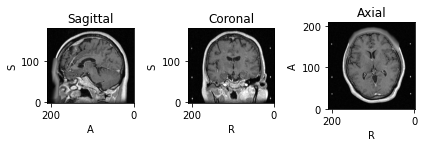

In [13]:
img_transform.plot()

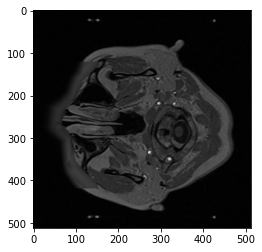

In [25]:
sliced = img_org.numpy()[0,:,:,12]
plt.imshow(sliced, cmap = "gray")


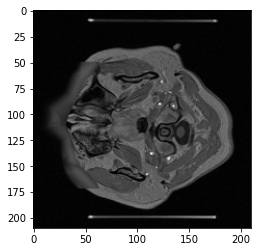

In [26]:
sliced_tr = img_transform.numpy()[0,:,:,12]
plt.imshow(sliced_tr, cmap = "gray")

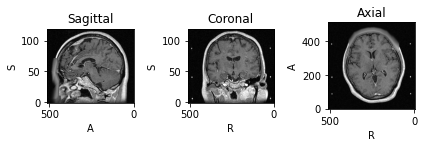

In [9]:
img.plot()

In [62]:
img = tio.ScalarImage('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_Label.nii.gz')
transform = tio.Resample((1, 1, 1), image_interpolation = 'nearest',label_interpolation="nearest")  
l_tr = transform(img)
# transform_2 = tio.Resize([256,256,120], image_interpolation='nearest')
# l_tr_2 = transform_2(l_tr)
l_tr

ScalarImage(shape: (1, 210, 210, 180); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.DoubleTensor; memory: 60.6 MiB)

In [63]:
transform_2 = tio.CropOrPad([256,256,120])
l_tr_2 = transform_2(l_tr)
l_tr_2

ScalarImage(shape: (1, 256, 256, 120); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.DoubleTensor; memory: 60.0 MiB)

In [53]:
img = tio.ScalarImage('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_Label.nii.gz')
transform = tio.Compose([tio.Resize([256,256,120], image_interpolation="nearest"),
                    tio.Resample((1,1,1), image_interpolation="nearest")])
final_img = transform(img)
final_img

ScalarImage(shape: (1, 210, 210, 180); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.DoubleTensor; memory: 60.6 MiB)

In [65]:
img_1 = tio.ScalarImage('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_ceT1.nii.g z')
transform = tio.Resample((1, 1, 1), image_interpolation = 'nearest',label_interpolation="nearest")  
l_tr_1 = transform(img_1)
# transform_2 = tio.Resize([256,256,120], image_interpolation='nearest')
# l_tr_2 = transform_2(l_tr)
l_tr_1

ScalarImage(shape: (1, 210, 210, 180); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.IntTensor; memory: 30.3 MiB)

In [66]:
transform_2 = tio.CropOrPad([256,256,120])
l_tr_21 = transform_2(l_tr_1)
l_tr_21

ScalarImage(shape: (1, 256, 256, 120); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.IntTensor; memory: 30.0 MiB)

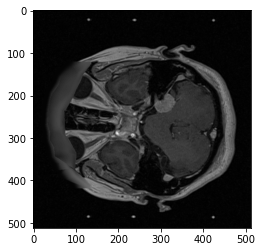

In [76]:
ls = img_1.numpy()[0,:,:,36]
plt.imshow(ls, cmap="gray")

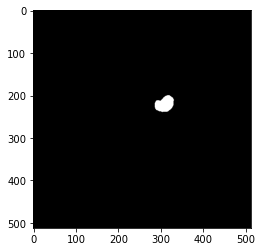

In [75]:
ls_tr = img.numpy()[0,:,:,36]
plt.imshow(ls_tr, cmap="gray")

In [49]:
np.unique(l_tr.numpy()[0,:,:,55])

array([0., 1.])

In [33]:
np.unique(l_tr.numpy()[0,:,:,36])

array([0.])

In [34]:
np.unique(img.numpy()[0,:,:,36])

array([0., 1.])

In [84]:
subject = tio.Subject(image=tio.ScalarImage('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_ceT1.nii.gz'), 
                    label=tio.LabelMap('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_Label.nii.gz'))

transformed = tio.Compose([
                    tio.Resample((1,1,1), image_interpolation = 'nearest',label_interpolation="nearest"),
                    tio.CropOrPad([256,256,120])])

transformed_subject = transformed(subject)

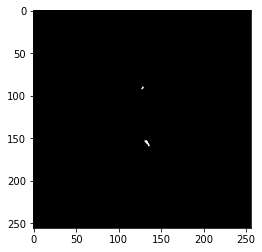

In [100]:
triall = nib.load('/home/shahad.hardan/Documents/crossMoDA20222/torch_3D_source/crossmoda2022_etz_9_Label.nii.gz')
plt.imshow(triall.get_fdata()[:,:,30], cmap="gray")

In [92]:
transformed_subject.label.shape[3]

120

### Final Torchio 

In [6]:
import re

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    return [ atof(c) for c in re.split(r'(\d+)', text) ]

In [157]:
INPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/training_source/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/torch_3D_source/"

sorted_folder = sorted(os.listdir(INPUT_FOLDER), key=natural_keys)
#When images are sorted, labels come first then original MRI 

for i in range(0,len(sorted_folder),2): 
    
    subject = tio.Subject(image=tio.ScalarImage(INPUT_FOLDER+sorted_folder[i+1]), 
                    label=tio.LabelMap(INPUT_FOLDER+sorted_folder[i]))
    depth = subject.image.shape[3]
    target_size = [256, 256, depth]
    transformed = tio.Compose([
                    tio.Resample((1,1,1), image_interpolation = 'nearest', label_interpolation="nearest"),
                    tio.CropOrPad(target_size)])
    transformed_subject = transformed(subject)
    transformed_subject.image.save(OUTPUT_FOLDER+sorted_folder[i+1])
    transformed_subject.label.save(OUTPUT_FOLDER+sorted_folder[i])

In [102]:
INPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/validation/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/torch_3D_Validation/"

for i in os.listdir(INPUT_FOLDER): 
    
    image = tio.ScalarImage(INPUT_FOLDER+i)
    depth = image.shape[3]
    target_size = [256, 256, depth]
    transformed = tio.Compose([
                    tio.Resample((1,1,1), image_interpolation = 'nearest', label_interpolation="nearest"),
                    tio.CropOrPad(target_size)])
    transformed_image = transformed(image)
    transformed_image.save(OUTPUT_FOLDER+i)

In [155]:
sorted_folder.index("crossmoda2022_etz_95_Label.nii.gz")

400

In [5]:
INPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/training_source/"
sorted_folder = sorted(os.listdir(INPUT_FOLDER), key=natural_keys)
sorted_folder.index("crossmoda2022_etz_10_Label.nii.gz")

230

In [59]:
# tio.Subject.relative_attribute_tolerance = 1e-3 # applies to all instances since it is a static attribute
# tio.Subject.absolute_attribute_tolerance = 1e-3

class MySubject(tio.Subject):
    def check_consistent_attribute(self, *args, **kwargs) -> None:
        kwargs['relative_tolerance'] = 1e-3
        kwargs['absolute_tolerance'] = 1e-3
        return super().check_consistent_attribute(*args, **kwargs)

subject = MySubject(image=tio.ScalarImage(INPUT_FOLDER+sorted_folder[231]), 
                    label=tio.LabelMap(INPUT_FOLDER+sorted_folder[230]))
depth = subject.image.shape[3]
target_size = [256, 256, depth]
transformed = tio.Compose([
                tio.Resample((1,1,1), image_interpolation = 'nearest', label_interpolation="nearest"),
                tio.CropOrPad(target_size),
                # tio.ToCanonical(),
                ])
transformed_subject = transformed(subject)

In [22]:
image_try = tio.ScalarImage(INPUT_FOLDER+sorted_folder[231])

In [23]:
print("Direction", image_try.direction)
image_try

Direction (-0.9999647947612735, 0.0, -0.008391020439112183, 0.0, -1.0, 0.0, -0.008391021275396099, 0.0, 0.999964794768291)


ScalarImage(shape: (1, 256, 256, 50); spacing: (0.82, 0.82, 1.50); orientation: LPS+; path: "/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2022_etz_10_ceT1.nii.gz")

In [21]:
label_try = tio.LabelMap(INPUT_FOLDER+sorted_folder[230])

In [24]:
print("Direction of Label", label_try.direction)
label_try

Direction of Label (-0.9999647142036687, -0.00040139775583485353, -0.008391020439100283, 0.00040139777000531104, -0.9999999194384995, 1.6840980650061312e-06, -0.008391020641469068, -1.6840981253015871e-06, 0.999964794766873)


LabelMap(shape: (1, 256, 256, 50); spacing: (0.82, 0.82, 1.50); orientation: LPS+; path: "/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2022_etz_10_Label.nii.gz")

In [75]:
INPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/training_source/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/torch_3D_source/"

list_1 = sorted(os.listdir(INPUT_FOLDER), key=natural_keys)
list_2 = sorted(os.listdir(OUTPUT_FOLDER), key= natural_keys)
main_list = sorted(list(set(list_1) - set(list_2)))

class MySubject(tio.Subject):
    def check_consistent_attribute(self, *args, **kwargs) -> None:
        kwargs['relative_tolerance'] = 1e-2
        kwargs['absolute_tolerance'] = 1e-2
        return super().check_consistent_attribute(*args, **kwargs)

In [ ]:
for i in range(0,len(main_list),2): 
    print(i)
    subject = MySubject(image=tio.ScalarImage(INPUT_FOLDER+main_list[i+1]), 
                    label=tio.LabelMap(INPUT_FOLDER+main_list[i]))
    depth = subject.image.shape[3]
    target_size = [256, 256, depth]
    transformed = tio.Compose([
                    tio.Resample((1,1,1), image_interpolation = 'nearest', label_interpolation="nearest"),
                    tio.CropOrPad(target_size)])
    transformed_subject = transformed(subject)
    transformed_subject.image.save(OUTPUT_FOLDER+main_list[i+1])
    transformed_subject.label.save(OUTPUT_FOLDER+main_list[i])

In [79]:
list_1 = sorted(os.listdir(INPUT_FOLDER), key=natural_keys)
list_2 = sorted(os.listdir(OUTPUT_FOLDER), key= natural_keys)
list_1 == list_2

True

In [13]:

subject = MySubject(image=tio.ScalarImage("/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2022_etz_84_ceT1.nii.gz"), 
                    label=tio.LabelMap("/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2022_etz_84_Label.nii.gz"))
target_size = [256, 256, 50]
transformed = tio.Compose([
                tio.Resample((1,1,1), image_interpolation = 'nearest', label_interpolation="nearest"),
                tio.CropOrPad(target_size),
                ])
transformed_subject = transformed(subject)

transformed_subject.label.save("/home/shahad.hardan/Documents/crossMoDA20222/torch_3D_source/crossmoda2022_etz_84_Label.nii.gz")

# print("Size of transformed label", transformed_subject.label.shape)
# print("Size of transformed image", transformed_subject.image.shape)

### Torchio Checks

In [83]:
img_org = tio.ScalarImage('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_ceT1.nii.gz')
img_org

ScalarImage(shape: (1, 512, 512, 120); spacing: (0.41, 0.41, 1.50); orientation: LPS+; path: "/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_ceT1.nii.gz")

In [84]:
transform_1 = tio.Resample((1, 1, 1), image_interpolation='bspline')  
img_transform_1 = transform_1(img_org)
img_transform_1

ScalarImage(shape: (1, 210, 210, 180); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.IntTensor; memory: 30.3 MiB)

In [85]:
resampled_depth = img_transform_1.shape[3]
target_size = [256, 256, resampled_depth] 
transform_2 = tio.CropOrPad(target_size)
img_transform_2 = transform_2(img_transform_1)
img_transform_2

ScalarImage(shape: (1, 256, 256, 180); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.IntTensor; memory: 45.0 MiB)

In [86]:
target_size = list(img_transform_1.shape[1:])
transform_3 = tio.CropOrPad(target_size)
img_transform_3 = transform_3(img_transform_2)
img_transform_3

ScalarImage(shape: (1, 210, 210, 180); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.IntTensor; memory: 30.3 MiB)

In [87]:
target_spacing = img_org.spacing
transform_4 = tio.Resample(target_spacing, image_interpolation='bspline')
img_transform_4 = transform_4(img_transform_3)
img_transform_4

ScalarImage(shape: (1, 512, 512, 120); spacing: (0.41, 0.41, 1.50); orientation: LPS+; dtype: torch.IntTensor; memory: 120.0 MiB)

In [88]:
img_org.save("/home/shahad.hardan/Documents/crossMoDA20222/ldn_1_ceT1_bspline/org_image.nii.gz")
img_transform_1.save("/home/shahad.hardan/Documents/crossMoDA20222/ldn_1_ceT1_bspline/pre_resampling.nii.gz") 
img_transform_2.save("/home/shahad.hardan/Documents/crossMoDA20222/ldn_1_ceT1_bspline/pre_CropOrPad.nii.gz")
img_transform_3.save("/home/shahad.hardan/Documents/crossMoDA20222/ldn_1_ceT1_bspline/post_CropOrPad.nii.gz")
img_transform_4.save("/home/shahad.hardan/Documents/crossMoDA20222/ldn_1_ceT1_bspline/post_resampling.nii.gz")

## RESAMPLING AGAIN 

In [107]:
subject = tio.Subject(image=tio.ScalarImage('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_ceT1.nii.gz'), 
                    label=tio.LabelMap('/home/shahad.hardan/Documents/crossMoDA20222/training_source/crossmoda2021_ldn_1_Label.nii.gz'))

transform_resampling = tio.Resample((1, 1, 1), image_interpolation="bspline")
subject_resampled = transform_resampling(subject)
print(subject_resampled.image)
print(subject_resampled.label)


target_size = [256, 256, subject_resampled.image.shape[3]]
transform_cropad = tio.CropOrPad(target_size)
subject_cropped = transform_cropad(subject_resampled)
print(subject_cropped.image)
print(subject_cropped.label)

ScalarImage(shape: (1, 210, 210, 180); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.IntTensor; memory: 30.3 MiB)
LabelMap(shape: (1, 210, 210, 180); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.DoubleTensor; memory: 60.6 MiB)
ScalarImage(shape: (1, 256, 256, 180); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.IntTensor; memory: 45.0 MiB)
LabelMap(shape: (1, 256, 256, 180); spacing: (1.00, 1.00, 1.00); orientation: LPS+; dtype: torch.DoubleTensor; memory: 90.0 MiB)


In [2]:
import re

def atof(text):
    try:
        retval = float(text)
    except ValueError:
        retval = text
    return retval

def natural_keys(text):
    return [ atof(c) for c in re.split(r'(\d+)', text) ]

In [3]:
class MySubject(tio.Subject):
    def check_consistent_attribute(self, *args, **kwargs) -> None:
        kwargs['relative_tolerance'] = 1e-2
        kwargs['absolute_tolerance'] = 1e-2
        return super().check_consistent_attribute(*args, **kwargs)

In [4]:
INPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/training_source/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/torch_3D_source_updated/"

sorted_folder = sorted(os.listdir(INPUT_FOLDER), key=natural_keys)
#When images are sorted, labels come first then original MRI 

label_files = [] 
img_files = [] 
org_img_size = [] 
org_img_spacing = [] 
org_label_size = [] 
org_label_spacing = []
resampling_size = [] 
cropping_size = []

for i in range(0,len(sorted_folder),2): 
    
    img_files.append(sorted_folder[i+1])
    label_files.append(sorted_folder[i])

    subject = MySubject(image=tio.ScalarImage(INPUT_FOLDER+sorted_folder[i+1]), 
                    label=tio.LabelMap(INPUT_FOLDER+sorted_folder[i]))
    
    org_img_size.append(list(subject.image.shape[1:]))
    org_img_spacing.append(subject.image.spacing)
    org_label_size.append(list(subject.label.shape[1:]))
    org_label_spacing.append(subject.label.spacing)

    transform_resampling = tio.Resample((1, 1, 1), image_interpolation="bspline", label_interpolation="nearest")
    subject_resampled = transform_resampling(subject)

    resampling_size.append(list(subject_resampled.image.shape[1:]))

    target_size = [256, 256, subject_resampled.image.shape[3]]
    transform_cropad = tio.CropOrPad(target_size)
    subject_cropped = transform_cropad(subject_resampled)

    cropping_size.append(list(subject_cropped.image.shape[1:]))

    subject_cropped.image.save(OUTPUT_FOLDER+sorted_folder[i+1])
    subject_cropped.label.save(OUTPUT_FOLDER+sorted_folder[i])

In [6]:
training_source_info = pd.DataFrame(list(zip(img_files, label_files, org_img_size, 
                                         org_img_spacing, org_label_size, org_label_spacing,
                                         resampling_size, cropping_size)), 
                                         columns =['img_files', 'label_files', 'org_img_size',
                                         'org_img_spacing', 'org_label_size', 'org_label_spacing',
                                         'resampling_size', 'cropping_size'])

training_source_info.to_csv("training_source_info.csv", header=True, index=False)

In [9]:
INPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/training_target/"
OUTPUT_FOLDER = "/home/shahad.hardan/Documents/crossMoDA20222/torch_3D_target_updated/"

img_files_t = [] 
org_img_size_t = [] 
org_img_spacing_t = [] 
resampling_size_t = [] 
cropping_size_t = []

for i in os.listdir(INPUT_FOLDER): 
    
    img_files_t.append(i)

    image = tio.ScalarImage(INPUT_FOLDER+i)
    
    org_img_size_t.append(list(image.shape[1:]))
    org_img_spacing_t.append(image.spacing)

    transform_resampling = tio.Resample((1, 1, 1), image_interpolation="bspline")
    image_resampled = transform_resampling(image)

    resampling_size_t.append(list(image_resampled.shape[1:]))

    target_size = [256, 256, image_resampled.shape[3]]
    transform_cropad = tio.CropOrPad(target_size)
    image_cropped = transform_cropad(image_resampled)

    cropping_size_t.append(list(image_cropped.shape[1:]))

    image_cropped.save(OUTPUT_FOLDER+i)

In [ ]:
training_target_info = pd.DataFrame(list(zip(img_files_t,org_img_size_t,org_img_spacing_t,
                                         resampling_size_t,cropping_size_t)), 
                                         columns =['img_files','org_img_size','org_img_spacing',
                                         'resampling_size','cropping_size'])

training_target_info.to_csv("training_target_info.csv", header=True, index=False)

In [6]:
os.path.abspath('.')

'/ssd_Samsung870_2T/docker_submission'

In [8]:
INPUT_FOLDER='/ssd_Samsung870_2T/docker_submission/input/'
OUTPUT_FOLDER='/ssd_Samsung870_2T/docker_submission/input_input/'

img_files_v = [] 
org_img_size_v = [] 
org_img_spacing_v = [] 
resampling_size_v = [] 
cropping_size_v = []

for i in os.listdir(INPUT_FOLDER): 
    
    img_files_v.append(i)

    image = tio.ScalarImage(INPUT_FOLDER+i)
    
    org_img_size_v.append(list(image.shape[1:]))
    org_img_spacing_v.append(image.spacing)

    transform_resampling = tio.Resample((1, 1, 1), image_interpolation="bspline")
    image_resampled = transform_resampling(image)

    resampling_size_v.append(list(image_resampled.shape[1:]))

    target_size = [256, 256, image_resampled.shape[3]]
    transform_cropad = tio.CropOrPad(target_size)
    image_cropped = transform_cropad(image_resampled)

    cropping_size_v.append(list(image_cropped.shape[1:]))

    image_cropped.save(OUTPUT_FOLDER+i)

KeyboardInterrupt: 

In [ ]:
validation_info = pd.DataFrame(list(zip(img_files_v, org_img_size_v, org_img_spacing_v, 
                                         resampling_size_v, cropping_size_v)), 
                                         columns =['img_files','org_img_size','org_img_spacing',
                                         'resampling_size','cropping_size'])

validation_info.to_csv("validation_info.csv", header=True, index=False)